# Includes

In [434]:
import random
import matplotlib.pyplot as plt
import math
from matplotlib.animation import FuncAnimation
import numpy as np
import copy

# Initialisation des paramètres

In [435]:
Npop = 500
Narchive = 20
Sp = 2
alpha = 0.7
Gmax = 500
pmut = 1
Ntour = 4

nb_x = 2
nb_fonction = 2
nb_contrainte = 1

# VK
# xmax = [7, 10]
# xmin = [2, 5]

# Hanne
# xmax = [12, 12]
# xmin = [0, 0]

# Deb 3
xmax = [1, 1]
xmin = [0, 0]

NewPop = 1 # 1 = recommencer avec une nouvelle population aléatoire ou 0 charger la population précédente
generationPop = 200 # recommencer à la génération 0 ou charger la génération précédente

# Initialisation variables

In [436]:
pop_anim = []

population = []
pop_admissible = []
archive = []

generation =[0]
Ninadmissible = np.zeros(Gmax + 1)
plotadmissible = []

gscale = []

first_eval = True

if NewPop == 0:
    generation[0] = generationPop

# Création de la classe individu

In [437]:
class Individu:
    def __init__(self, x):
        self.x = x
        self.f = np.zeros(nb_fonction)
        self.g = np.zeros(nb_contrainte)
        self.rank = 0
        self.fviol = 0

    def evaluationObjectifs(self):
        # === Hanne 1, 4 ===
        # self.f[0] = self.x[0]
        # self.f[1] = self.x[1]

        # === Hanne 2 ===
        # self.f[0] = self.x[0]**2
        # self.f[1] = self.x[1]**2

        # === Hanne 3 ===
        # self.f[0] = self.x[0]**(1/2)
        # self.f[1] = self.x[1]**(1/2)

        # === Hanne 5 ===
        # self.f[0] = int(self.x[0]) + 0.5 + (self.x[0]- int(self.x[0]))*math.sin(2*math.pi*(self.x[1]-int(self.x[1])))
        # self.f[1] = int(self.x[1]) + 0.5 + (self.x[0]- int(self.x[0]))*math.cos(2*math.pi*(self.x[1]-int(self.x[1])))

        # === V.Kelner ===
        # self.f[0] = -self.x[0]-self.x[1]**2
        # self.f[1] = -self.x[0]**2-self.x[1]

        #=== Deb3 === multifrontale
        def f (x1):
            return x1
        
        def g (x2):
            return 2 - math.exp(-((x2-0.2)/0.04)**2)-0.8*math.exp(-((x2-0.6)/0.4)**2)
        
        def h(x1):
            return 1/f(x1)
        
        self.f[0] = f(self.x[0])
        self.f[1] = g(self.x[1])*h(self.x[0])

    def evaluationContraintes(self):
        # === Hanne 1, 2, 3, 5 ===
        self.g[0] = (self.x[0] + self.x[1] - 5)

        # === Hanne 4 ===
        # self.g[0] = self.x[1] - 5 + (0.5*self.x[0]*math.sin(4*self.x[0]))

        # === V.Kelner ===
        # self.g[0] = 12 - self.x[0] - self.x[1]
        # self.g[1] = self.x[0]**2 + 10*self.x[0] - self.x[1]**2 + 16*self.x[1] - 80

        # === Deb3 ===
        self.g[0] = 0

    def evaluationFacteurViol(self):
        for i in range(0, len(self.g)):
            if(self.g[i] > 0):
                self.g[i] = 0
            self.fviol += self.g[i] * gscale[i]
            
    def modif_rank(self, rank):
        self.rank = rank

# Création des fonctions

In [438]:
# Affichage de la population
def plot_population(population, generation, ax):
    ax.clear()
    ax.plot([individu.f[0] for individu in population], [individu.f[1] for individu in population], 'ro')
    ax.set_ylabel('f2')
    ax.set_xlabel('f1')
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 10)
    ax.set_title(f'Population jusqu\'à la génération {generation[-1]}')

def plot_admissible(plotadmissible):
    plt.figure()
    plt.plot([individu.f[0] for individu in plotadmissible], [individu.f[1] for individu in plotadmissible], 'ro', markersize=1 )
    plt.ylabel('f2')
    plt.xlabel('f1')
    plt.title('Population admissible')
    plt.grid(True)
    plt.show()

def plot_inadmissible(Ninadmissible, generation):
    plt.figure()
    plt.plot(generation, Ninadmissible, 'r')
    plt.ylabel('Nombre d\'individus inadmissibles')
    plt.xlabel('Génération')
    plt.xlim(0, Gmax)
    plt.ylim(0, Npop)
    plt.title('Evolution du nombre d\'individus inadmissibles')
    plt.grid(True)
    plt.show()

def scale(population):
    sumgmin = 0

    for i in range(0, nb_contrainte):
        gscale.append(population[0].g[i])

    for i in range(0, nb_contrainte):
        for individu in population:
            if individu.g[i] < gscale[i]:
                gscale[i] = abs(individu.g[i])
        sumgmin += gscale[i]

    if sumgmin != 0:
        for i in range(0, nb_contrainte):
            gscale[i] = gscale[i]/sumgmin

        if nb_contrainte > 1:
            for i in range(0, nb_contrainte):
                gscale[i] = 1 - gscale[i]
    else:
        for i in range(0, nb_contrainte):
            gscale[i] = 1 

def ranking(population, archive):
    for i in pop_admissible:
        for j in pop_admissible:
            if i!=j: # ne compare pas avec le individu hors contrainte
                if population[j].f[0] <= population[i].f[0] and population[j].f[1] <= population[i].f[1]:
                    population[i].rank += 1

        if population[i].rank == 0 and population[i].fviol == 0:
            archive.append(copy.deepcopy(population[i]))

def archivage(archive, Narchive):
    temp = []
    for i in archive:
        i.modif_rank(0)
        for j in archive:
            if i!=j:
                if j.f[0] <= i.f[0] and j.f[1] <= i.f[1]:
                    i.rank += 1
                    break
        if i.rank == 0:
            temp.append(i)

    archive.clear()
    N = Narchive
    if len(temp) < N:
        N = len(temp)

    for i in range(N):
        archive.append(random.choice(temp))

def plot_pareto(population, Npop):
    pareto = []

    for i in range(Npop):
        if population[i].rank == 0 and population[i].fviol == 0:
            pareto.append(population[i])

    # Plot points from the Pareto front
    plt.plot([individu.f[0] for individu in pareto], [individu.f[1] for individu in pareto], 'ro', label='Pareto Front')
    plt.plot([individu.f[0] for individu in archive], [individu.f[1] for individu in archive], 'bo', markerfacecolor = 'none', label='Archive')

    # Set labels and title
    plt.ylabel('f2')
    plt.xlabel('f1')
    #plt.xlim(-110, -30)
    #plt.ylim(-55, -10)
    plt.title('Front de Pareto')

    plt.grid(True)

    # Show legend
    plt.legend()

    # Display the plot
    plt.show()

# Initialisation de la population
def initialisation(population, Npop, NewPop, generation): #si NewPop = True alors on crée une nouvelle population
    if NewPop:
        for i in range(Npop):
            x = np.zeros(nb_x)
            for j in range(nb_x):
                x[j] = random.uniform(xmin[j], xmax[j])
            population.append(Individu(x))
    else: #charger la population depuis un fichier csv
        with open(f'population_{generation[0]}.csv', 'r') as f:
            for line in f:
                x1, x2, f1, f2 = line.split(';')
                population.append(Individu([float(x1), float(x2)]))

def evaluation(population):
    for individu in population:
        individu.evaluationContraintes()

    if first_eval:
        scale(population)
    
    pop_admissible.clear()
    i=0
    for individu in population:
        individu.evaluationFacteurViol()
        
        if individu.fviol == 0:
            individu.evaluationObjectifs()
            plotadmissible.append(individu)
            pop_admissible.append(i)
        else:
            Ninadmissible[generation[-1]] += 1
        i += 1

# Sélection des parents
def selection_tournoi(population, Ntour):
    new_population = []
    for i in range(Npop):
        best = []
        for j in range(Ntour):
            individu = random.choice(population)
            if len(best) == 0:
                best.clear()
                best.append(individu)
            elif individu.fviol > best[0].fviol :
                best.clear()
                best.append(individu)
            elif individu.rank < best[0].rank:
                best.clear()
                best.append(individu)
            else:
                best.append(individu)
        new_population.append(random.choice(best))
    population.clear()
    for individu in new_population:
        population.append(individu)


# Croisement
def croisement(population, Npop):
    new_population = []
    while len(new_population) < Npop :
         # Tirer au hasard deux individus
        parent1 = random.choice(population)
        population.remove(parent1)
        parent2 = random.choice(population)
        population.remove(parent2)

        # calcul de lambda
        u = random.uniform(0,1)
        Y = u*(1+2*alpha)-alpha

        x = np.zeros((2,nb_x))
        for i in range(nb_x):
            # Calcul des enfants
            x[0][i] = Y*parent1.x[i] + (1-Y)*parent2.x[i]
            x[1][i] = (1-Y)*parent1.x[i] + Y*parent2.x[i]

        # Vérification des bornes
        for i in range(2):
            ok = True
            for j in range(nb_x):
                if x[i][j] > xmax[j] or x[i][j] < xmin[j]:
                    ok = False
            if ok:
                new_population.append(Individu(x[i]))
            else:
                if random.choice([True, False]):
                    new_population.append(parent1)
                else:
                    new_population.append(parent2)

    population.clear()
    for individu in new_population:
         population.append(individu)

# Mutation
def mutation(population, pmut, generation, xmax, xmin, Gmax):
    for individu in population:
        if random.uniform(0,100) < pmut:
            xi = random.choice([0,nb_x-1])
            delta = random.choice([-1,1])
            if delta == 1:
                pas = random.uniform(0,1)*(xmax[xi]-individu.x[xi])*(1-generation[-1]/(Gmax+generation[0]))
            else:
                pas = random.uniform(0,1)*(individu.x[xi]-xmin[xi])*(1-generation[-1]/(Gmax+generation[0]))
            individu.x[xi] = individu.x[xi] + delta*pas

# sauvegarder population dans un fichier csv
def save_population(population, generation):
    with open(f'population_{generation[-1]}.csv', 'w') as f:
        for individu in population:
            f.write(f'{individu.x[0]};{individu.x[1]};{individu.f[0]};{individu.f[1]}\n')

# Programme principal

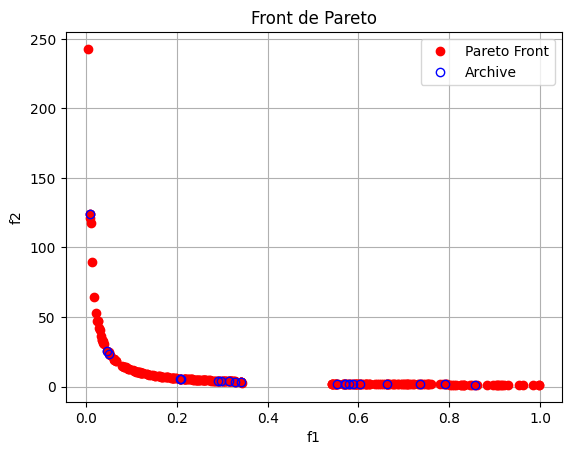

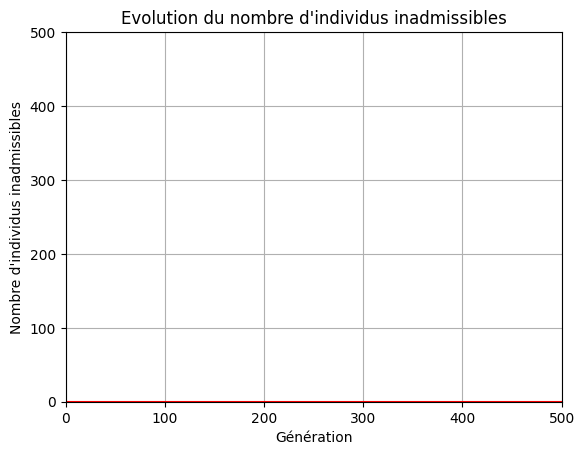

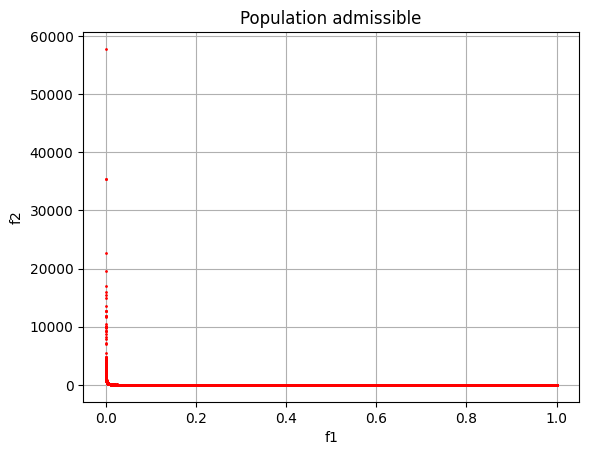

In [439]:
fig, ax = plt.subplots()

# Initialisation de la population
initialisation(population, Npop, NewPop, generation)

#pop_anim.append(population.copy())

# Evaluation de la population
evaluation(population)
first_eval = False
ranking(population, archive)

# Boucle principale

for i in range(Gmax):
    # Incrémentation du nombre de génération
    generation.append(generation[-1] + 1)

    # Sélection des parents
    selection_tournoi(population, Ntour)

    # Croisement
    croisement(population, Npop)

    # Mutation
    mutation(population, pmut, generation, xmax, xmin, Gmax)

    #pop_anim.append(population.copy())

    # Evaluation de la population
    evaluation(population)
    ranking(population, archive)
    archivage(archive, Narchive)

save_population(population, generation)
# Animation de la population
#ani = FuncAnimation(fig, plot_population, frames=pop_anim, fargs=(generation, ax), interval=100, repeat=False)
#ani.save('evolution_population.gif', writer='pillow')

plot_pareto(population, Npop)
plot_inadmissible(Ninadmissible, generation)
plot_admissible(plotadmissible)

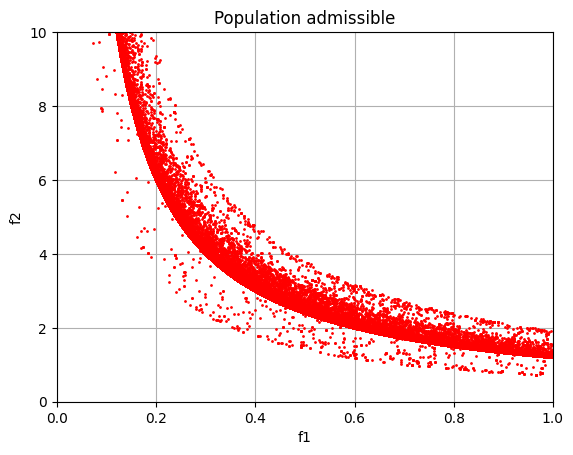

In [440]:
plt.figure()
plt.plot([individu.f[0] for individu in plotadmissible], [individu.f[1] for individu in plotadmissible], 'ro', markersize=1 )
plt.ylabel('f2')
plt.xlabel('f1')
plt.title('Population admissible')
plt.grid(True)
plt.xlim(0, 1)
plt.ylim(0, 10)
plt.show()